In [1]:
import numpy as np
import pandas as pd
import geopy, random, tqdm
import geopandas
import fake_useragent

from geopy.geocoders import Nominatim
from geopy.extra.rate_limiter import RateLimiter
from fake_useragent import UserAgent

In [2]:
#import data

df = pd.read_csv("C://Users/haikalef/Downloads/archive/london_crime_by_lsoa.csv")
df.head()

,lsoa_code,borough,major_category,minor_category,value,year,month
0,E01001116,Croydon,Burglary,Burglary in Other Buildings,0,2016,11
1,E01001646,Greenwich,Violence Against the Person,Other violence,0,2016,11
2,E01000677,Bromley,Violence Against the Person,Other violence,0,2015,5
3,E01003774,Redbridge,Burglary,Burglary in Other Buildings,0,2016,3
4,E01004563,Wandsworth,Robbery,Personal Property,0,2008,6


In [3]:
'''
Preprocessing 
    -> Check Missing Value
        -> Missing Value Imputation
    -> Geocoding
        -> merubah dari kolom 'borough' menjadi lat and long
    
Hypetothical Questions:
1. Boxplot: Crime terbanyak ada pada tahun berapa?
2. Pie Chart: Berdasarkan kasus pertama, crime/kejahatan apa yang paling banyak terjadi?
3. Histogram: Bagaimana distribusi dari kolom value dari kasus nomor 2?

    
Data Visualization
    1. Line Chart untuk membandingkan pertahun
    2. Count Plot untuk melihat distribusi 
    3. Line Chart
    4. Count Plot
'''

"\nPreprocessing \n    -> Check Missing Value\n        -> Missing Value Imputation\n    -> Geocoding\n        -> merubah dari kolom 'borough' menjadi lat and long\n    \nHypetothical Question\n    1. di tahun berapakah yang terjadi crime paling banyak?\n        1.1. dari bulan manakah yang paling banyak terjadi?\n    2. kota manakah yang paling banyak terjadi crime?\n    3. bulan manakah yang paling banyak terjadi crime?\n    4. major category mana yang paling banyak crime?\n    \nData Visualization\n    1. Line Chart untuk membandingkan pertahun\n    2. Count Plot untuk melihat distribusi \n    3. Line Chart\n    4. Count Plot\n"

In [4]:
#preprocessing
#check missing value

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13490604 entries, 0 to 13490603
Data columns (total 7 columns):
 #   Column          Dtype 
---  ------          ----- 
 0   lsoa_code       object
 1   borough         object
 2   major_category  object
 3   minor_category  object
 4   value           int64 
 5   year            int64 
 6   month           int64 
dtypes: int64(3), object(4)
memory usage: 720.5+ MB


In [5]:
df.isnull().sum()

lsoa_code         0
borough           0
major_category    0
minor_category    0
value             0
year              0
month             0
dtype: int64

Cek nilai unique setiap kolomnya

In [6]:
df['borough'].unique()

array(['Croydon', 'Greenwich', 'Bromley', 'Redbridge', 'Wandsworth',
       'Ealing', 'Hounslow', 'Newham', 'Sutton', 'Haringey', 'Lambeth',
       'Richmond upon Thames', 'Hillingdon', 'Havering',
       'Barking and Dagenham', 'Kingston upon Thames', 'Westminster',
       'Hackney', 'Enfield', 'Harrow', 'Lewisham', 'Brent', 'Southwark',
       'Barnet', 'Waltham Forest', 'Camden', 'Bexley',
       'Kensington and Chelsea', 'Islington', 'Tower Hamlets',
       'Hammersmith and Fulham', 'Merton', 'City of London'], dtype=object)

In [7]:
df['major_category'].unique()

array(['Burglary', 'Violence Against the Person', 'Robbery',
       'Theft and Handling', 'Criminal Damage', 'Drugs',
       'Fraud or Forgery', 'Other Notifiable Offences', 'Sexual Offences'],
      dtype=object)

In [8]:
df['minor_category'].unique()

array(['Burglary in Other Buildings', 'Other violence',
       'Personal Property', 'Other Theft', 'Offensive Weapon',
       'Criminal Damage To Other Building', 'Theft/Taking of Pedal Cycle',
       'Motor Vehicle Interference & Tampering',
       'Theft/Taking Of Motor Vehicle', 'Wounding/GBH',
       'Other Theft Person', 'Common Assault', 'Theft From Shops',
       'Possession Of Drugs', 'Harassment', 'Handling Stolen Goods',
       'Criminal Damage To Dwelling', 'Burglary in a Dwelling',
       'Criminal Damage To Motor Vehicle', 'Other Criminal Damage',
       'Counted per Victim', 'Going Equipped', 'Other Fraud & Forgery',
       'Assault with Injury', 'Drug Trafficking', 'Other Drugs',
       'Business Property', 'Other Notifiable', 'Other Sexual',
       'Theft From Motor Vehicle', 'Rape', 'Murder'], dtype=object)

In [9]:
df['value'].dtypes

dtype('int64')

karena df['value'] data type nya semua int, maka dapat dipastikan pada kolom value tidak ada data selain integer, dimana kita berasumsi jika ada data selain int maka kita menganggap data tersebut missing value

In [10]:
df['year'].unique()

array([2016, 2015, 2008, 2012, 2010, 2013, 2014, 2011, 2009], dtype=int64)

In [11]:
df['month'].unique()

array([11,  5,  3,  6,  7,  4,  9,  8, 12,  1, 10,  2], dtype=int64)

In [12]:
len(df)

13490604

In [13]:
#membuat random user agent
def get_random_ua():
    ua = UserAgent()
    ua = ua.data
    
    list_browser = list(ua['browsers'].keys())
    random_browser = random.choice(list_browser)
    
    max_len_ua = len(ua['browsers'][random_browser])
    idx = [i for i in range(max_len_ua)]
    random_idx = random.choice(idx)
    random_ua = ua['browsers'][random_browser][random_idx]
    
    return random_ua

get_random_ua()

'Opera/9.80 (X11; Linux x86_64; U; bg) Presto/2.8.131 Version/11.10'

In [14]:
#contoh
ua = UserAgent()
locator = Nominatim(user_agent=get_random_ua())
location = locator.geocode("Champ de Mars, Paris, France")
print(f"Latitude = {location.latitude}, Longitude = {location.longitude}")

Latitude = 48.85614465, Longitude = 2.297820393322227


In [15]:
#membuat data frame baru untuk mengisi latitude dan longitude berdasarkan kolom borough
new_df_city = {}

for city in df['borough'].unique():
    locator = Nominatim(user_agent=get_random_ua())
    location = locator.geocode(city)
    lat_long = [location.latitude, location.longitude]
    new_df_city.update({city:lat_long})
        
new_df_city

{'Croydon': [51.3713049, -0.101957],
 'Greenwich': [51.4820845, -0.0045417],
 'Bromley': [51.4028046, 0.0148142],
 'Redbridge': [51.5763203, 0.0454097],
 'Wandsworth': [51.4570271, -0.1932607],
 'Ealing': [51.5126553, -0.3051952],
 'Hounslow': [51.4686132, -0.3613471],
 'Newham': [51.5300157, 0.029309078788513746],
 'Sutton': [30.51216325, -100.53841807826248],
 'Haringey': [51.587929849999995, -0.10541771297992009],
 'Lambeth': [51.5013012, -0.117287],
 'Richmond upon Thames': [51.4405529, -0.3076394377337949],
 'Hillingdon': [51.542519299999995, -0.44833493117949663],
 'Havering': [51.54437325, -0.14431380000000021],
 'Barking and Dagenham': [51.5540907, 0.15048888801039415],
 'Kingston upon Thames': [51.4096275, -0.3062621],
 'Westminster': [51.5004439, -0.1265398],
 'Hackney': [51.5432402, -0.0493621],
 'Enfield': [51.6520851, -0.0810175],
 'Harrow': [51.596827149999996, -0.3373046180437286],
 'Lewisham': [51.4624325, -0.0101331],
 'Brent': [51.5639957, -0.27590641378489267],
 'Sou

In [16]:
#memisahkan nilai lat dan long dari dataframe yang diatas, dimana akan ada 2 kolom lat dan long

temp1 = []
temp2 = []

for i in tqdm.tqdm(range(0, len(df))):
    temp1.append(new_df_city[df['borough'][i]][0])
    temp2.append(new_df_city[df['borough'][i]][1])
df['lat'] = temp1
df['long'] = temp2

100%|██████████| 13490604/13490604 [02:00<00:00, 111718.93it/s]


In [17]:
df

,lsoa_code,borough,major_category,minor_category,value,year,month,lat,long
0,E01001116,Croydon,Burglary,Burglary in Other Buildings,0,2016,11,51.371305,-0.101957
1,E01001646,Greenwich,Violence Against the Person,Other violence,0,2016,11,51.482084,-0.004542
2,E01000677,Bromley,Violence Against the Person,Other violence,0,2015,5,51.402805,0.014814
3,E01003774,Redbridge,Burglary,Burglary in Other Buildings,0,2016,3,51.576320,0.045410
4,E01004563,Wandsworth,Robbery,Personal Property,0,2008,6,51.457027,-0.193261
...,...,...,...,...,...,...,...,...,...
13490599,E01000504,Brent,Criminal Damage,Criminal Damage To Dwelling,0,2015,2,51.563996,-0.275906
13490600,E01002504,Hillingdon,Robbery,Personal Property,1,2015,6,51.542519,-0.448335
13490601,E01004165,Sutton,Burglary,Burglary in a Dwelling,0,2011,2,30.512163,-100.538418
13490602,E01001134,Croydon,Robbery,Business Property,0,2011,5,51.371305,-0.101957


In [18]:
df_new = df.drop(['lsoa_code'], axis=1)

Setelah mem-preprocessing data ini, tahap selanjutnya yaitu melakukan hypetothical questions, yaitu kita memunculkan pertanyaan dari data yang telah kita proses berdasarkan sudut pandang kita sendiri. 

Hypetothical Questions:
1. Boxplot: Crime terbanyak ada pada tahun berapa?
2. Pie Chart: Berdasarkan kasus pertama, crime/kejahatan apa yang paling banyak terjadi?
3. Histogram: Bagaimana distribusi dari kolom value dari kasus nomor 2?

1. 5 kota dan tahun berapa yang terjadi crime terbanyak?
2. di tahun berapakah yang terjadi crime paling banyak?
   2.1. dari bulan manakah yang paling banyak terjadi?
3. bulan manakah yang paling banyak terjadi crime?
4. major category mana yang paling banyak crime?

In [19]:
df_new

,borough,major_category,minor_category,value,year,month,lat,long
0,Croydon,Burglary,Burglary in Other Buildings,0,2016,11,51.371305,-0.101957
1,Greenwich,Violence Against the Person,Other violence,0,2016,11,51.482084,-0.004542
2,Bromley,Violence Against the Person,Other violence,0,2015,5,51.402805,0.014814
3,Redbridge,Burglary,Burglary in Other Buildings,0,2016,3,51.576320,0.045410
4,Wandsworth,Robbery,Personal Property,0,2008,6,51.457027,-0.193261
...,...,...,...,...,...,...,...,...
13490599,Brent,Criminal Damage,Criminal Damage To Dwelling,0,2015,2,51.563996,-0.275906
13490600,Hillingdon,Robbery,Personal Property,1,2015,6,51.542519,-0.448335
13490601,Sutton,Burglary,Burglary in a Dwelling,0,2011,2,30.512163,-100.538418
13490602,Croydon,Robbery,Business Property,0,2011,5,51.371305,-0.101957


Untuk menjawab pertanyaan nomor 1, kita perlu membuat dataframe baru yang hanya berisikan kolom borough, value, dan year. Karena kita akan menggunakan boxplot untuk melihat crime terbanyak terjadi pada tahun berapa

In [47]:
df_new2 = df_new[['borough', 'value', 'year']]
df_new2.sort_values(['value'], ascending=False, axis=0, inplace=True) #sort 100 data teratas untuk mengambil nilai crime 100 teratas

df_new2_top100 = df_new2.head(100) 
df_new2_top100

C:\Users\haikalef\AppData\Local\Temp\ipykernel_15916\3453770058.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_new2.sort_values(['value'], ascending=False, axis=0, inplace=True)


,borough,value,year
1608904,Tower Hamlets,309,2012
13423472,Westminster,300,2008
3277025,Westminster,288,2008
12317524,Westminster,286,2008
9579977,Westminster,281,2009
...,...,...,...
8688152,Westminster,180,2012
10205891,Westminster,180,2012
13394650,Westminster,179,2012
7415415,Tower Hamlets,179,2011


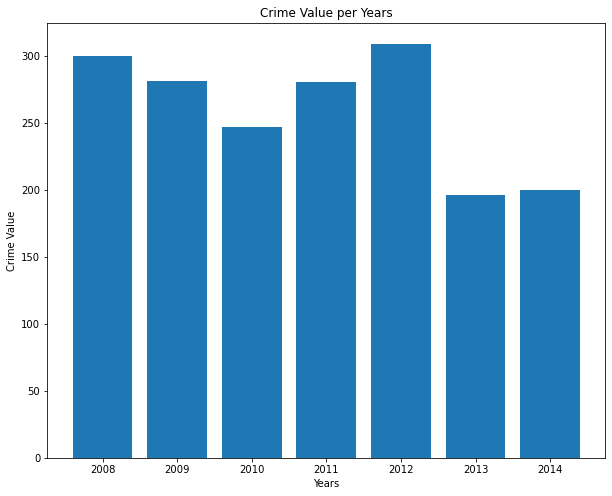

In [21]:
#boxplot: crime terbanyak pada tahun berapa
import matplotlib.pyplot as plt

fig = plt.figure(figsize=(10,8))
x_year = df_new2_top100['year']
y_value = df_new2_top100['value']

plt.bar(x_year, y_value)
plt.xlabel("Years")
plt.ylabel("Crime Value")
plt.title("Crime Value per Years")

plt.show()

In [22]:
#pie chart= karena dari data atas tahun 2012 yang terjadi banyak crime, maka ditahun 2012, kejahatan apa yang paling banyak terjadi?

df_2012 = df_new[df_new['year'] == 2012][['major_category', 'value', 'year']]
df_2012.sort_values(['value'], ascending=False, axis=0, inplace=True)

df_new3_top100 = df_2012.head(100)
df_new3_top100

,major_category,value,year
1608904,Drugs,309,2012
9077246,Theft and Handling,240,2012
13313421,Theft and Handling,236,2012
10161081,Theft and Handling,221,2012
10414804,Theft and Handling,220,2012
...,...,...,...
634631,Theft and Handling,92,2012
491263,Theft and Handling,91,2012
8633470,Theft and Handling,91,2012
10422531,Theft and Handling,90,2012


In [23]:
print(list(df_new3_top100['major_category'].value_counts().index))
print(list(df_new3_top100['major_category'].value_counts().values))

['Theft and Handling', 'Drugs']
[96, 4]


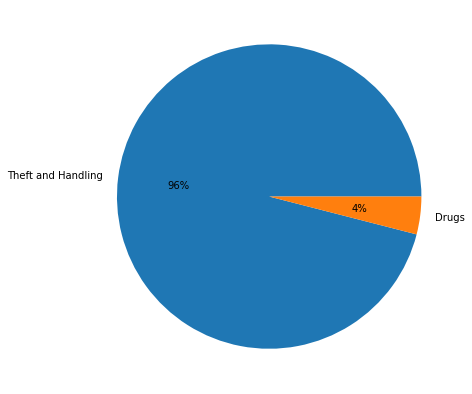

In [24]:
fig = plt.figure(figsize =(10, 7))
label = list(df_new3_top100['major_category'].value_counts().index)
data = list(df_new3_top100['major_category'].value_counts().values)

plt.pie(data, labels=label, autopct='%1.0f%%')
plt.show()

Text(0.5, 1.0, 'Distribusi dari kolom 100 value terbanyak 2012')

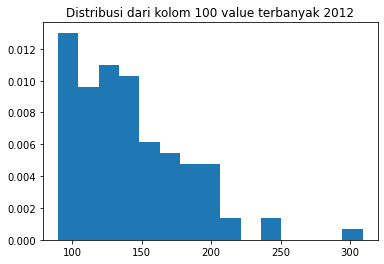

In [25]:
#histogram: bagaimana distribusi dari kolom value diatas

n_bins = 15
x = df_new3_top100['value']
    
plt.hist(x, n_bins, density = True, 
         histtype ='bar')

plt.title("Distribusi dari kolom 100 value terbanyak 2012")

#distribusi eksponensial

In [26]:
!pip install wordcloud

In [27]:
from wordcloud import WordCloud, STOPWORDS

print('Wordcloud is installed and imported!')

Wordcloud is installed and imported!


In [28]:
#gunakan stopwords, gunakan set untuk menghapus stopwords yang berlebihan
stopwords = set(STOPWORDS)

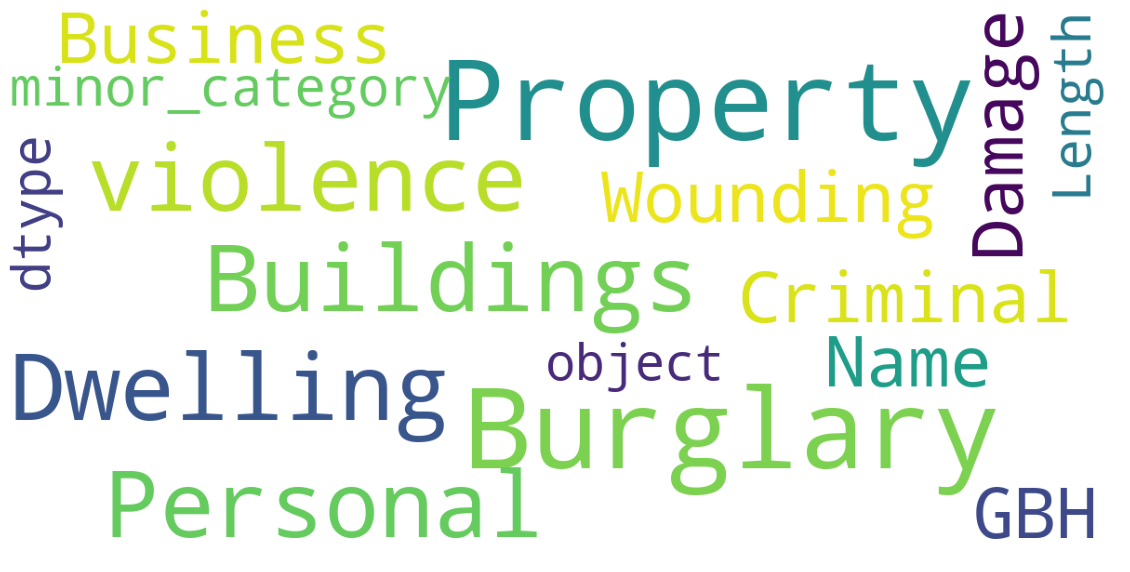

In [29]:
#instantiate a word cloud object
def Mywordcloud (data, title=None):
    wordcloud = WordCloud(
        background_color = 'white',
        stopwords = stopwords,
        max_words = 1000,
        max_font_size = 40,
        scale = 3,
        random_state = 1
    ).generate(str(data))
    
    fig = plt.figure(1, figsize=(20,20))
    plt.axis('off')
    if title:
        fig.suptitle(title, fontsize=20)
        fig.subplots_adjust(top=2.3)
        
    plt.imshow(wordcloud)
    plt.show()

Mywordcloud(df_new["minor_category"].dropna())

In [36]:
#folium maps
!pip install folium

#import the libarary
import folium

print('folium has been imported')

folium has been imported


In [37]:
#memvisualisasikan top 100 crime pada tahun 2012 dengan menggunakan folium map
df_2012_folium = df_new[df_new['year'] == 2012][['major_category', 'value', 'year', 'lat', 'long']]
df_2012_folium.sort_values(['value'], ascending=False, axis=0, inplace=True)

df_new4_top100 = df_2012_folium.head(100)
df_new4_top100

,major_category,value,year,lat,long
1608904,Drugs,309,2012,51.128863,1.298669
9077246,Theft and Handling,240,2012,51.500444,-0.126540
13313421,Theft and Handling,236,2012,51.500444,-0.126540
10161081,Theft and Handling,221,2012,51.500444,-0.126540
10414804,Theft and Handling,220,2012,51.500444,-0.126540
...,...,...,...,...,...
634631,Theft and Handling,92,2012,51.500444,-0.126540
491263,Theft and Handling,91,2012,51.500444,-0.126540
8633470,Theft and Handling,91,2012,51.500444,-0.126540
10422531,Theft and Handling,90,2012,51.542519,-0.448335


In [45]:
#karena ini merupakan data london_crime, maka kita tampilkan map london dengan folium map
#insert lat long London

latitude = 51.507351
longitude = -0.127758

london_map = folium.Map(location=[latitude, longitude], zoom_start=10)
london_map

In [46]:
from folium import plugins

#instantiate a mark cluster object for the crime in the dataframe
crimes = plugins.MarkerCluster().add_to(london_map) 

for lat, lng, label in zip(df_new4_top100.lat, df_new4_top100.long, df_new4_top100.major_category):
    folium.Marker(
        location=[lat, lng],
        icon=None,
        popup=label
    ).add_to(crimes)
    
#display map
london_map